# Load raw dataset

In [1]:
import pickle
import numpy as np
import pandas as pd
from os import listdir
from os.path import join, isfile, expandvars

# data
zenith = 'z20' # 'random' 
table = 'regressor_5sgm_exp30m_z20_xy_flip.pickle'
path = f'{expandvars("$HOME")}/E4/irf_{zenith}/crab/'
dataset = join(path, table)

# models
cnnname = 'cleaner_5sgm_filter12_z20'
savename = 'regressor_5sgm_filter6_4convs_dense1e4_z20' 

# dataset 
if '.pickle' in table:
    with open(dataset,'rb') as f: ds = pickle.load(f)
    infotable = join(path, table.replace('.pickle', '.dat'))
    gammatable = join(path, table.replace('.pickle', '_gammapy.txt'))
elif '.npy' in table:
    ds = np.load(dataset, allow_pickle=True, encoding='latin1', fix_imports=True).flat[0]
    infotable = join(path, table.replace('.npy', '.dat'))
    gammatable = join(path, table.replace('.npy', '_gammapy.txt'))
    
ds = np.array(ds['DS'])
ds = ds.reshape(ds.shape[0], ds.shape[1], ds.shape[2], 1)
ds.shape

(20000, 200, 200, 1)

# Infotable

In [2]:
infodata = pd.read_csv(infotable, sep=' ', header=0).sort_values(by=['seed'])
infodata.head()

,name,seed,start,stop,duration,source_ra,source_dec,point_ra,point_dec,offset,irf,fov,sim_time
14000,crab_00001,1,0,100,100,316.641513,12.589385,316.529421,12.904256,0.333312,North_z20_S_0.5h_LST,2.5,6.472037
14001,crab_00002,2,0,100,100,16.841739,78.034907,18.877416,77.993683,0.424728,North_z20_0.5h_LST,2.5,6.277098
14002,crab_00003,3,0,100,100,340.483309,-17.472847,340.130408,-17.623667,0.368734,North_z20_S_0.5h_LST,2.5,6.194221
14003,crab_00004,4,0,100,100,344.849066,86.535858,329.619289,84.942323,1.941093,North_z20_N_0.5h_LST,2.5,6.153547
14004,crab_00005,5,0,100,100,214.863376,34.357314,216.119150,33.122741,1.616953,North_z20_N_0.5h_LST,2.5,6.129901


# Gammatable

In [3]:
gammadata = pd.read_csv(gammatable, sep=' ', header=0).sort_values(by=['seed'])
gammadata.head()

,seed,loc_ra,loc_dec,counts_on,counts_off,excess,excess_err,sigma,correct_irf,selected_irf
0,8001,160.074066,5.495648,NaN,NaN,NaN,NaN,NaN,North_z20_S_0.5h_LST,/home/dipiano/caldb/data/cta/prod5/Pro...
1,8002,288.501191,10.680641,NaN,NaN,NaN,NaN,NaN,North_z20_N_0.5h_LST,/home/dipiano/caldb/data/cta/prod5/Pro...
2,8003,243.508483,80.010392,NaN,NaN,NaN,NaN,NaN,North_z20_N_0.5h_LST,/home/dipiano/caldb/data/cta/prod5/Pro...
3,8004,181.084998,73.805329,NaN,NaN,NaN,NaN,NaN,North_z20_N_0.5h_LST,/home/dipiano/caldb/data/cta/prod5/Pro...
4,8005,237.250146,-79.382836,NaN,NaN,NaN,NaN,NaN,North_z20_N_0.5h_LST,/home/dipiano/caldb/data/cta/prod5/Pro...


# Pick seed

In [4]:
idx = np.random.choice(range(len(ds)))
idx = 4205
# find seed to get the original heatmap
seed = idx + 1
print(seed)

4206


In [5]:
row = infodata[infodata['seed']==seed]
row

,name,seed,start,stop,duration,source_ra,source_dec,point_ra,point_dec,offset,irf,fov,sim_time
8205,crab_04206,4206,0,100,100,199.103694,46.733195,198.856759,46.25239,0.509974,North_z20_N_0.5h_LST,2.5,6.075739


In [6]:
grow = gammadata[gammadata['seed']==seed]
grow

,name,seed,start,stop,duration,source_ra,source_dec,point_ra,point_dec,offset,irf,fov,sim_time
8205,crab_04206,4206,0,100,100,199.103694,46.733195,198.856759,46.25239,0.509974,North_z20_N_0.5h_LST,2.5,6.075739


# Set WCS

In [7]:
from astroai.tools.utils import *

binning = 200
pixelsize = (2 * row['fov'].values[0]) / binning
point_ref = (binning / 2) + (pixelsize / 2)
w = set_wcs(point_ra=row['point_ra'].values[0], point_dec=row['point_dec'].values[0], 
            point_ref=point_ref, pixelsize=pixelsize)

# Denoise dataset

In [8]:
import tensorflow as tf

root = f'{expandvars("$HOME")}/astroAI/astroai/'
model = tf.keras.models.load_model(join(root, 'models/cnn_cleaner', f'{cnnname}.keras'))
predictions = model.predict(ds)

2024-04-09 17:12:40.179847: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-09 17:12:41.032395: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-04-09 17:12:41.032424: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-04-09 17:12:42.590988: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-

625/625 [==============================] - 22s 35ms/step


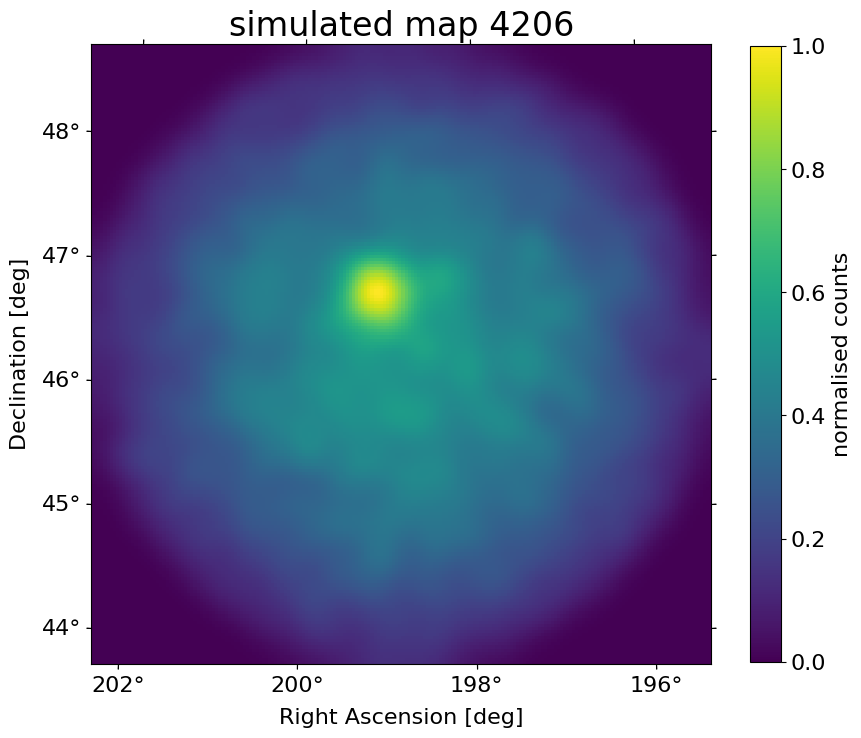

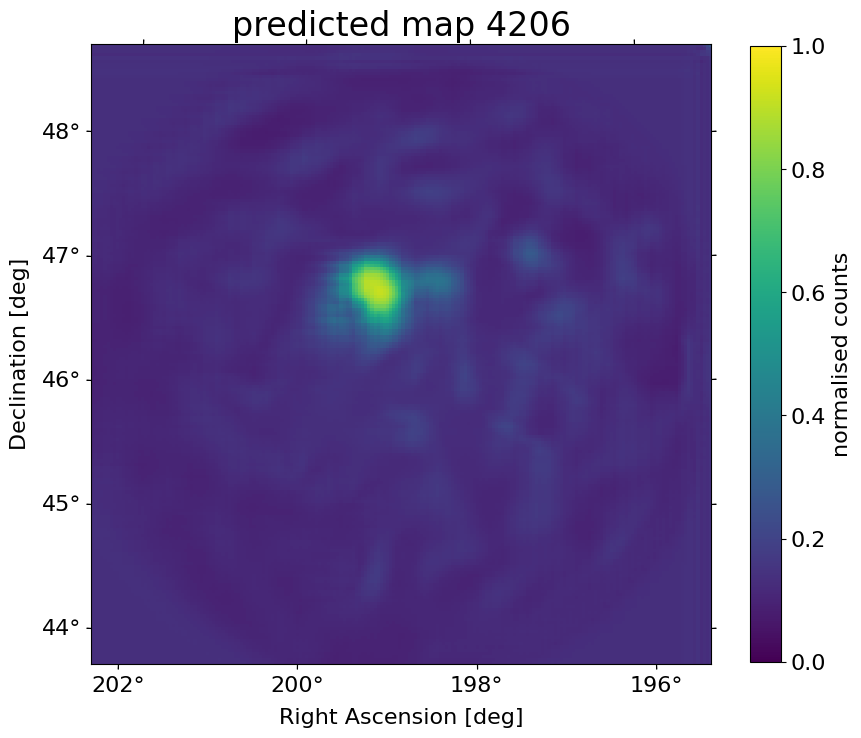

In [9]:
import astropy.units as u
from matplotlib.lines import Line2D

radius_deg = 0.2
radius_pix = radius_deg/0.025
figsize = (10, 10)
fs = 16

# NOISY
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111, projection=w)
    
img = ax.imshow(ds[idx], vmin=0, vmax=1)
ax.coords['ra'].set_format_unit(u.deg)
ax.coords['dec'].set_format_unit(u.deg)
ax.set_ylabel('Declination [deg]', fontsize=fs)
ax.set_xlabel('Right Ascension [deg]', fontsize=fs)
ax.set_title(f'simulated map {seed}', fontsize=fs*1.5)

cb = fig.colorbar(img, ax=ax, shrink=0.8)
ax.tick_params(axis='both', labelsize=fs)
cb.ax.tick_params(labelsize=fs)
cb.set_label('normalised counts', fontsize=fs)

fig.savefig(f'img/heatmap_{seed}_noisy.png')
plt.show()

# CLEAN
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111, projection=w)

img = ax.imshow(predictions[idx], vmin=0, vmax=1)
ax.coords['ra'].set_format_unit(u.deg)
ax.coords['dec'].set_format_unit(u.deg)
ax.set_ylabel('Declination [deg]', fontsize=fs)
ax.set_xlabel('Right Ascension [deg]', fontsize=fs)
ax.set_title(f'predicted map {seed}', fontsize=fs*1.5)

cb = fig.colorbar(img, ax=ax, shrink=0.8)
ax.tick_params(axis='both', labelsize=fs)
cb.ax.tick_params(labelsize=fs)
cb.set_label('normalised counts', fontsize=fs)

fig.savefig(f'img/heatmap_{seed}_clean.png')
plt.show()

# Localise candidates

In [10]:
import tensorflow as tf

model = tf.keras.models.load_model(f'../models/cnn_regressor/{savename}.keras')
candidates = model.predict(predictions) * binning

625/625 [==============================] - 43s 69ms/step


In [11]:
from astroai.tools.utils import *

binning = 200
pixelsize = (2 * row['fov'].values[0]) / binning
point_ref = (binning / 2) + (pixelsize / 2)
w = set_wcs(point_ra=row['point_ra'].values[0], point_dec=row['point_dec'].values[0], 
            point_ref=point_ref, pixelsize=pixelsize)

# TRUE
true_sky = SkyCoord(ra=row['source_ra'].values[0], dec=row['source_dec'].values[0], unit='deg', frame='icrs')
x, y = w.world_to_pixel(true_sky) 
true_sky = true_sky.ra.deg, true_sky.dec.deg
true_pix = x, y

# PREDICTION
pred_pix = candidates[idx]
sky = w.pixel_to_world(pred_pix[0], pred_pix[1])
pred_sky = sky.ra.deg, sky.dec.deg

# GAMMAPY
gamma_sky = SkyCoord(ra=grow['source_ra'].values[0], dec=grow['source_dec'].values[0], unit='deg', frame='icrs')
x, y = w.world_to_pixel(gamma_sky) 
gamma_sky = gamma_sky.ra.deg, gamma_sky.dec.deg
gamma_pix = x, y

print(f'SEED: {seed}')
print('---- PIX')
print(f"true: {true_pix}")
print(f"prediction: {pred_pix}")
print(f"gammapy: {gamma_pix}")
print('---- SKY')
print(f"true: {true_sky} ")
print(f"prediction: {pred_sky}")
print(f"gammapy: {gamma_sky}")

SEED: 4206
---- PIX
true: (array(92.25484521), array(118.26775331))
prediction: [ 90.3745  118.67255]
gammapy: (array(92.25484521), array(118.26775331))
---- SKY
true: (199.10369357015787, 46.73319491383731) 
prediction: (199.1723355240314, 46.743147980660986)
gammapy: (199.10369357015787, 46.73319491383731)


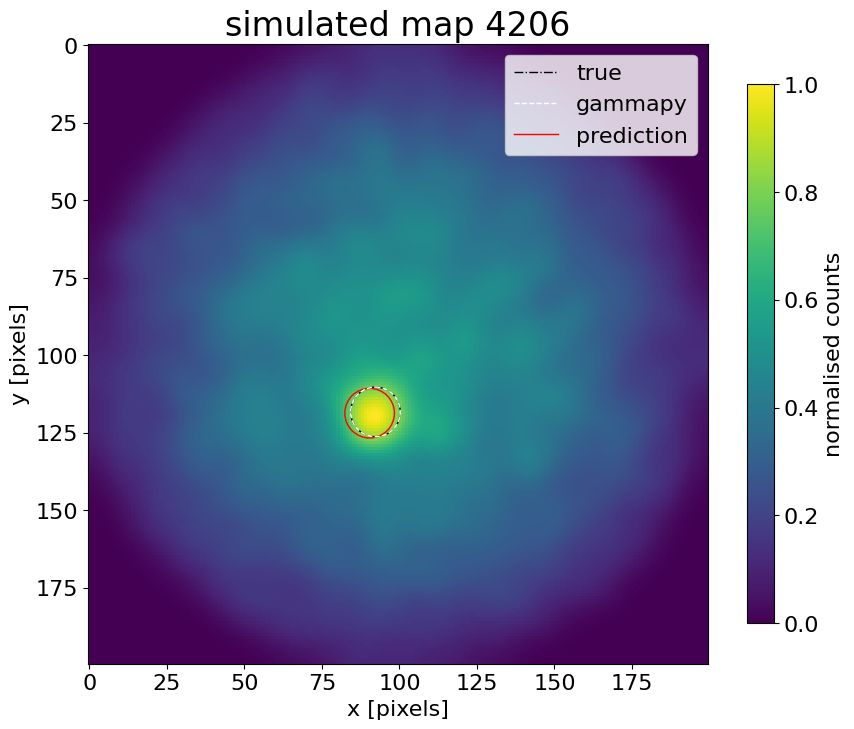

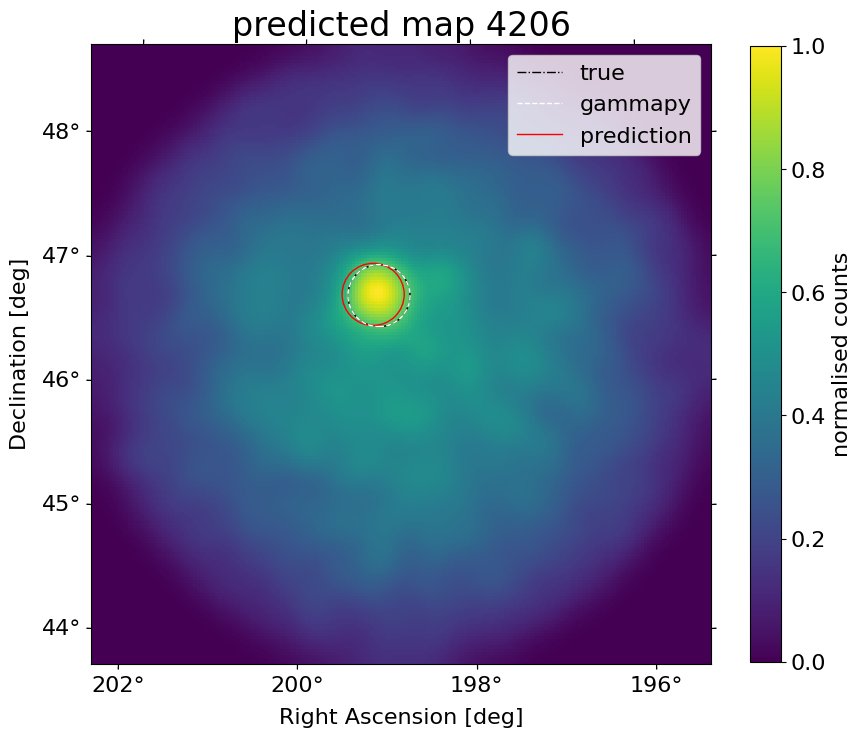

In [12]:
import astropy.units as u
from matplotlib.lines import Line2D

radius_deg = 0.2
radius_pix = radius_deg/0.025
sz = 2e3

# LEGENDS
custom_lines = [Line2D([0], [0], color='k', lw=1, ls='-.'),
                Line2D([0], [0], color='w', lw=1, ls='--'),
                Line2D([0], [0], color='r', lw=1, ls='-')]

# PIX
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.imshow(ds[idx], vmin=0, vmax=1)
ax.add_patch(plt.Circle((true_pix), radius=radius_pix, edgecolor='k', facecolor='none', ls='-.'))
ax.add_patch(plt.Circle((pred_pix), radius=radius_pix, edgecolor='r', facecolor='none', ls='-'))
ax.add_patch(plt.Circle((gamma_pix), radius=radius_pix, edgecolor='w', facecolor='none', ls='--'))
ax.set_ylabel('y [pixels]', fontsize=fs)
ax.set_xlabel('x [pixels]', fontsize=fs)
ax.set_title(f'simulated map {seed}', fontsize=fs*1.5)
ax.legend(custom_lines, ['true', 'gammapy', 'prediction'], fontsize=fs)

cb = fig.colorbar(img, ax=ax, shrink=0.7)
ax.tick_params(axis='both', labelsize=fs)
cb.ax.tick_params(labelsize=fs)
cb.set_label('normalised counts', fontsize=fs)

fig.savefig(f'img/heatmap_{seed}_pix.png')
plt.show()

# SKY
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111, projection=w)
ax.imshow(ds[idx], vmin=0, vmax=1)
ax.coords['ra'].set_format_unit(u.deg)
ax.coords['dec'].set_format_unit(u.deg)
ax.scatter(true_sky[0], true_sky[1], transform=ax.get_transform('icrs'), s=sz,
              edgecolor='k', facecolor='none', ls='-.')
ax.scatter(pred_sky[0], pred_sky[1], transform=ax.get_transform('icrs'), s=sz,
              edgecolor='r', facecolor='none', ls='-')
ax.scatter(gamma_sky[0], gamma_sky[1], transform=ax.get_transform('icrs'), s=sz,
              edgecolor='w', facecolor='none', ls='--')
ax.set_ylabel('Declination [deg]', fontsize=fs)
ax.set_xlabel('Right Ascension [deg]', fontsize=fs)
ax.set_title(f'predicted map {seed}', fontsize=fs*1.5)
ax.legend(custom_lines, ['true', 'gammapy', 'prediction'], fontsize=fs)

cb = fig.colorbar(img, ax=ax, shrink=0.8)
ax.tick_params(axis='both', labelsize=fs)
cb.ax.tick_params(labelsize=fs)
cb.set_label('normalised counts', fontsize=fs)

fig.savefig(f'img/heatmap_{seed}_sky.png')
plt.show()


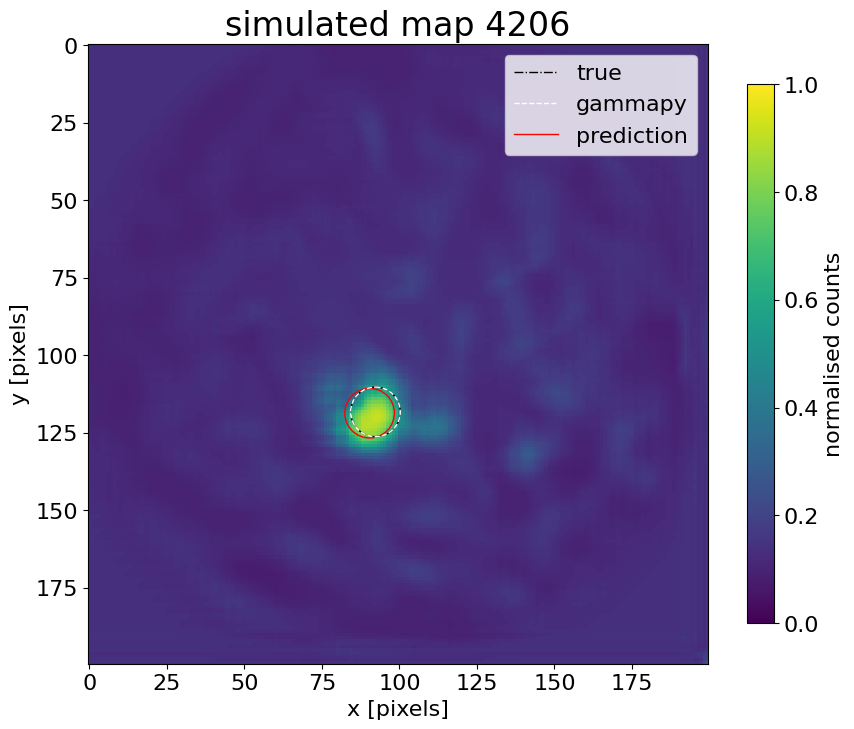

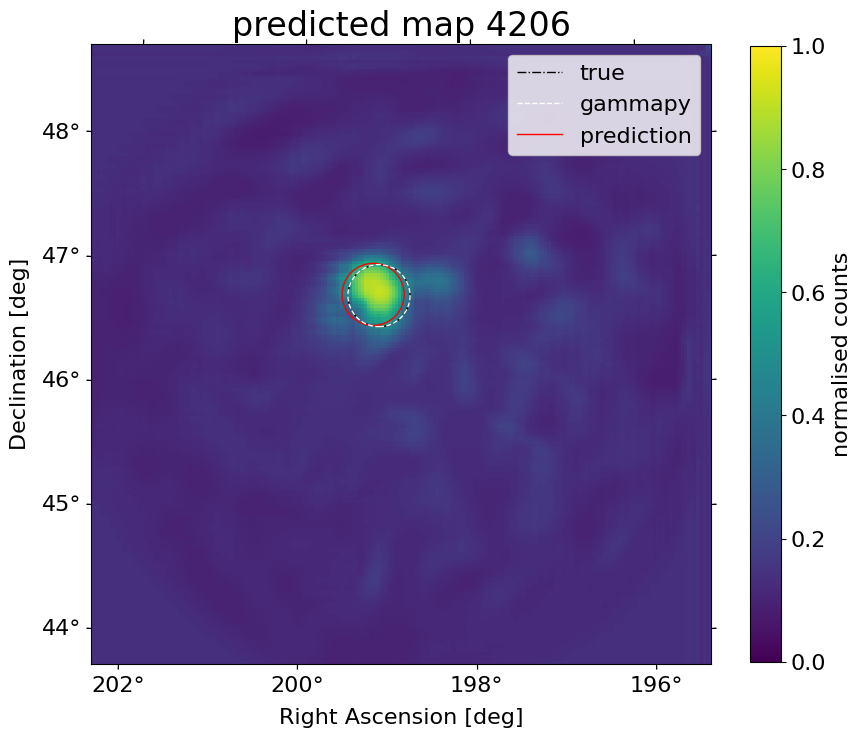

In [13]:
import astropy.units as u
from matplotlib.lines import Line2D

radius_deg = 0.2
radius_pix = radius_deg/0.025
sz = 2e3

# LEGENDS
custom_lines = [Line2D([0], [0], color='k', lw=1, ls='-.'),
                Line2D([0], [0], color='w', lw=1, ls='--'),
                Line2D([0], [0], color='r', lw=1, ls='-')]

# PIX
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.imshow(predictions[idx], vmin=0, vmax=1)
ax.add_patch(plt.Circle((true_pix), radius=radius_pix, edgecolor='k', facecolor='none', ls='-.'))
ax.add_patch(plt.Circle((pred_pix), radius=radius_pix, edgecolor='r', facecolor='none', ls='-'))
ax.add_patch(plt.Circle((gamma_pix), radius=radius_pix, edgecolor='w', facecolor='none', ls='--'))
ax.set_ylabel('y [pixels]', fontsize=fs)
ax.set_xlabel('x [pixels]', fontsize=fs)
ax.set_title(f'simulated map {seed}', fontsize=fs*1.5)
ax.legend(custom_lines, ['true', 'gammapy', 'prediction'], fontsize=fs)

cb = fig.colorbar(img, ax=ax, shrink=0.7)
ax.tick_params(axis='both', labelsize=fs)
cb.ax.tick_params(labelsize=fs)
cb.set_label('normalised counts', fontsize=fs)

fig.savefig(f'img/heatmap_{seed}_pix.png')
plt.show()

# SKY
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111, projection=w)
ax.imshow(predictions[idx], vmin=0, vmax=1)
ax.coords['ra'].set_format_unit(u.deg)
ax.coords['dec'].set_format_unit(u.deg)
ax.scatter(true_sky[0], true_sky[1], transform=ax.get_transform('icrs'), s=sz,
              edgecolor='k', facecolor='none', ls='-.')
ax.scatter(pred_sky[0], pred_sky[1], transform=ax.get_transform('icrs'), s=sz,
              edgecolor='r', facecolor='none', ls='-')
ax.scatter(gamma_sky[0], gamma_sky[1], transform=ax.get_transform('icrs'), s=sz,
              edgecolor='w', facecolor='none', ls='--')
ax.set_ylabel('Declination [deg]', fontsize=fs)
ax.set_xlabel('Right Ascension [deg]', fontsize=fs)
ax.set_title(f'predicted map {seed}', fontsize=fs*1.5)
ax.legend(custom_lines, ['true', 'gammapy', 'prediction'], fontsize=fs)

cb = fig.colorbar(img, ax=ax, shrink=0.8)
ax.tick_params(axis='both', labelsize=fs)
cb.ax.tick_params(labelsize=fs)
cb.set_label('normalised counts', fontsize=fs)

fig.savefig(f'img/heatmap_{seed}_sky.png')
plt.show()


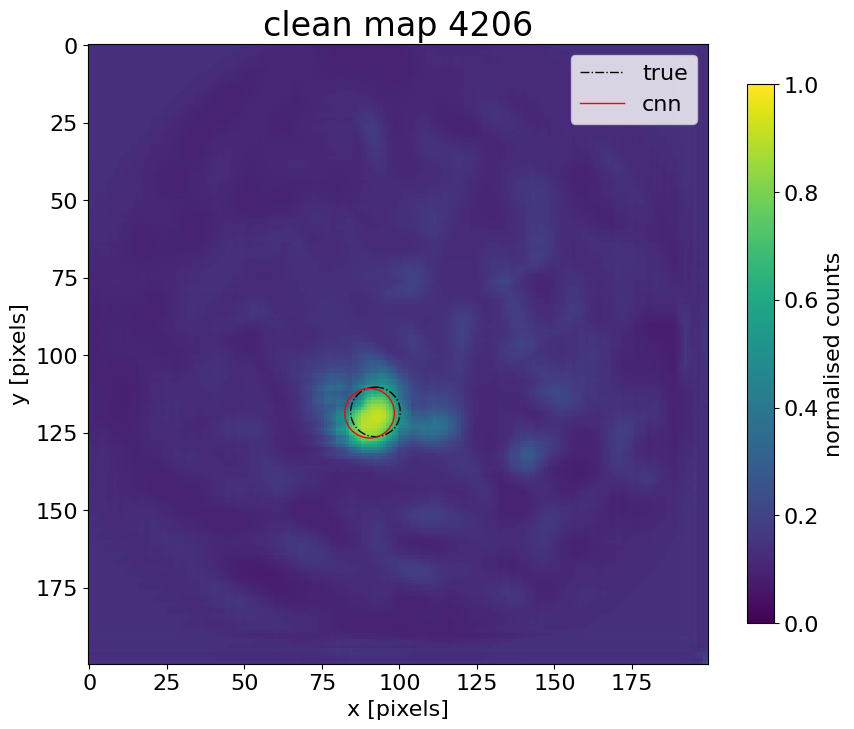

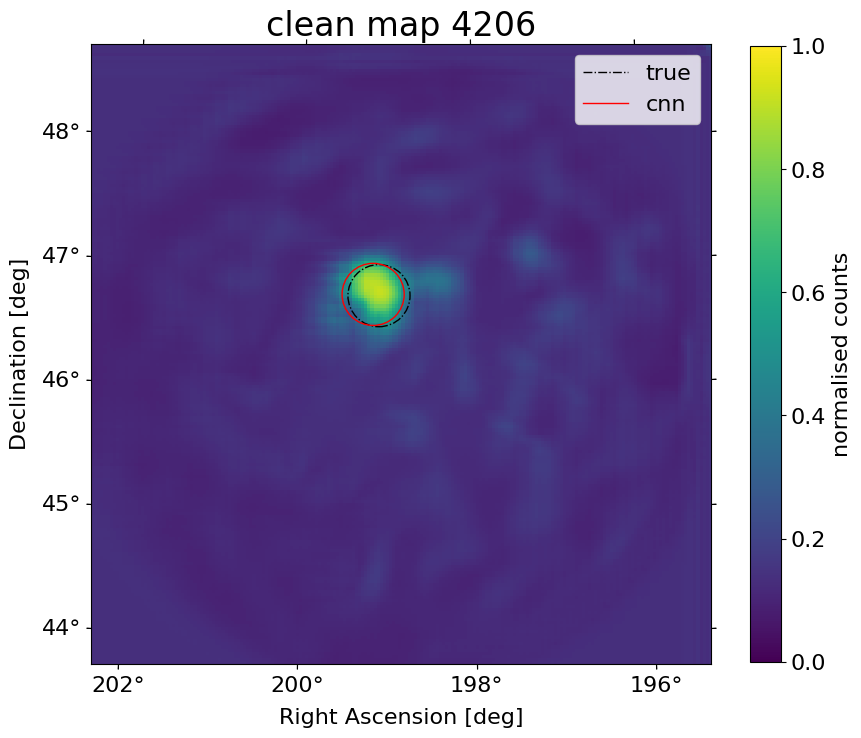

In [16]:
import astropy.units as u
from matplotlib.lines import Line2D

radius_deg = 0.2
radius_pix = radius_deg/0.025
sz = 2e3

# LEGENDS
custom_lines = [Line2D([0], [0], color='k', lw=1, ls='-.'),
                Line2D([0], [0], color='r', lw=1, ls='-')]

# PIX
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.imshow(predictions[idx], vmin=0, vmax=1)
ax.add_patch(plt.Circle((true_pix), radius=radius_pix, edgecolor='k', facecolor='none', ls='-.'))
ax.add_patch(plt.Circle((pred_pix), radius=radius_pix, edgecolor='r', facecolor='none', ls='-'))
ax.set_ylabel('y [pixels]', fontsize=fs)
ax.set_xlabel('x [pixels]', fontsize=fs)
ax.set_title(f'clean map {seed}', fontsize=fs*1.5)
ax.legend(custom_lines, ['true', 'cnn'], fontsize=fs)

cb = fig.colorbar(img, ax=ax, shrink=0.7)
ax.tick_params(axis='both', labelsize=fs)
cb.ax.tick_params(labelsize=fs)
cb.set_label('normalised counts', fontsize=fs)

fig.savefig(f'img/heatmap_{seed}_pix.png')
plt.show()

# SKY
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111, projection=w)
ax.imshow(predictions[idx], vmin=0, vmax=1)
ax.coords['ra'].set_format_unit(u.deg)
ax.coords['dec'].set_format_unit(u.deg)
ax.scatter(true_sky[0], true_sky[1], transform=ax.get_transform('icrs'), s=sz,
              edgecolor='k', facecolor='none', ls='-.')
ax.scatter(pred_sky[0], pred_sky[1], transform=ax.get_transform('icrs'), s=sz,
              edgecolor='r', facecolor='none', ls='-')
ax.set_ylabel('Declination [deg]', fontsize=fs)
ax.set_xlabel('Right Ascension [deg]', fontsize=fs)
ax.set_title(f'clean map {seed}', fontsize=fs*1.5)
ax.legend(custom_lines, ['true', 'cnn'], fontsize=fs)

cb = fig.colorbar(img, ax=ax, shrink=0.8)
ax.tick_params(axis='both', labelsize=fs)
cb.ax.tick_params(labelsize=fs)
cb.set_label('normalised counts', fontsize=fs)

fig.savefig(f'img/heatmap_{seed}_sky.png')
plt.show()
